In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [2]:
# First : Processing the dataset

def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

In [3]:
def get_combined_data():
    # reading train data
    
    train, test = get_data()
    
    target = train.SalePrice
    train.drop(['SalePrice'], axis = 1, inplace = True)
    
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'Id'], inplace=True,axis=1)
    return combined, target   

In [4]:
#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [5]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [6]:
# function to get columns that dont have any missing values

def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [7]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [8]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


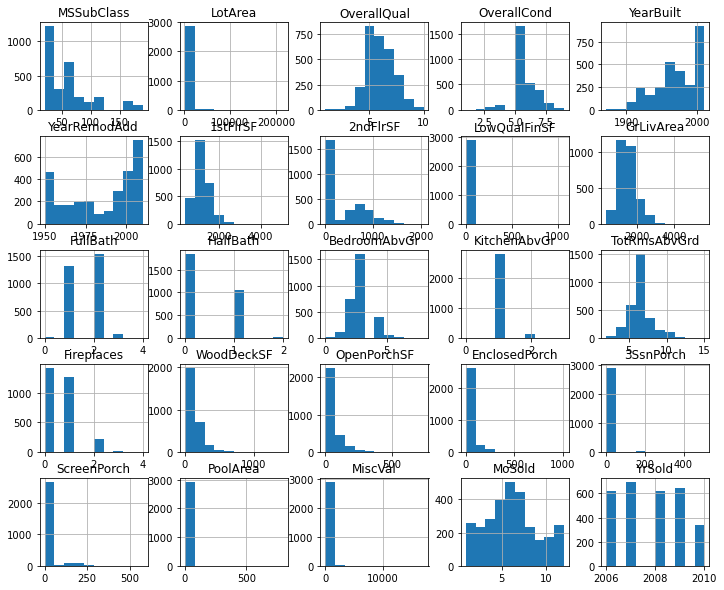

In [9]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

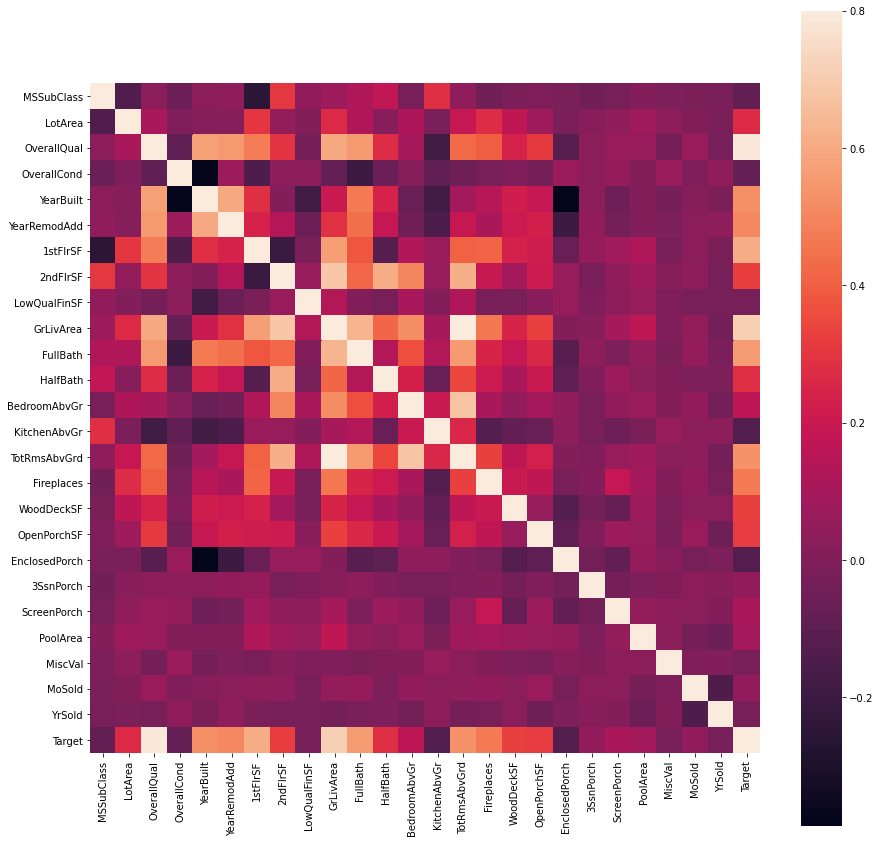

In [10]:
# correlation between features
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [11]:
# We will encode the categorical features using one hot encoding.

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [12]:
# split back combined dataFrame to training data and test data
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

In [17]:
# Second : Make the Deep Neural Network 

NN_model = Sequential()

# Input Layers:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layer
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# Output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer ='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               19200     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [28]:
# define a checkpoint callback 

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [29]:
# Third : Train the model :
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/500
21/37 [================>.............] - ETA: 0s - loss: 14749.6758 - mean_absolute_error: 14749.6758
Epoch 00001: val_loss improved from inf to 29630.59180, saving model to Weights-001--29630.59180.hdf5
37/37 [==============================] - 0s 5ms/step - loss: 15367.5684 - mean_absolute_error: 15367.5684 - val_loss: 29630.5918 - val_mean_absolute_error: 29630.5918
Epoch 2/500
20/37 [===============>..............] - ETA: 0s - loss: 18086.8066 - mean_absolute_error: 18086.8066
Epoch 00002: val_loss improved from 29630.59180 to 20489.28516, saving model to Weights-002--20489.28516.hdf5
37/37 [==============================] - 0s 4ms/step - loss: 16059.8457 - mean_absolute_error: 16059.8457 - val_loss: 20489.2852 - val_mean_absolute_error: 20489.2852
Epoch 3/500
23/37 [=================>............] - ETA: 0s - loss: 16727.0488 - mean_absolute_error: 16727.0488
Epoch 00003: val_loss did not improve from 20489.28516
37/37 [==============================] - 0s 3ms/step - lo

Epoch 25/500
33/37 [=========================>....] - ETA: 0s - loss: 15420.9502 - mean_absolute_error: 15420.9502
Epoch 00025: val_loss did not improve from 19631.83789
37/37 [==============================] - 0s 4ms/step - loss: 15305.5068 - mean_absolute_error: 15305.5068 - val_loss: 23402.4844 - val_mean_absolute_error: 23402.4844
Epoch 26/500
24/37 [==================>...........] - ETA: 0s - loss: 15315.2725 - mean_absolute_error: 15315.2725
Epoch 00026: val_loss did not improve from 19631.83789
37/37 [==============================] - 0s 3ms/step - loss: 14906.0049 - mean_absolute_error: 14906.0049 - val_loss: 23570.7578 - val_mean_absolute_error: 23570.7578
Epoch 27/500
37/37 [==============================] - ETA: 0s - loss: 15994.2949 - mean_absolute_error: 15994.2949
Epoch 00027: val_loss did not improve from 19631.83789
37/37 [==============================] - 0s 4ms/step - loss: 15994.2949 - mean_absolute_error: 15994.2949 - val_loss: 20466.7637 - val_mean_absolute_error: 

Epoch 74/500
19/37 [==============>...............] - ETA: 0s - loss: 13058.0186 - mean_absolute_error: 13058.0186
Epoch 00074: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 13356.0293 - mean_absolute_error: 13356.0293 - val_loss: 21574.7578 - val_mean_absolute_error: 21574.7578
Epoch 75/500
22/37 [================>.............] - ETA: 0s - loss: 14759.4775 - mean_absolute_error: 14759.4775
Epoch 00075: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 14513.6250 - mean_absolute_error: 14513.6250 - val_loss: 21529.8613 - val_mean_absolute_error: 21529.8613
Epoch 76/500
23/37 [=================>............] - ETA: 0s - loss: 16289.0879 - mean_absolute_error: 16289.087 - ETA: 0s - loss: 14035.2939 - mean_absolute_error: 14035.2939
Epoch 00076: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 14617.7178 - mean_absolute_error:

24/37 [==================>...........] - ETA: 0s - loss: 12507.7539 - mean_absolute_error: 12507.7539
Epoch 00122: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12657.3545 - mean_absolute_error: 12657.3545 - val_loss: 21393.6504 - val_mean_absolute_error: 21393.6504
Epoch 123/500
25/37 [===================>..........] - ETA: 0s - loss: 12976.0947 - mean_absolute_error: 12976.0947
Epoch 00123: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12577.9824 - mean_absolute_error: 12577.9824 - val_loss: 20905.7285 - val_mean_absolute_error: 20905.7285
Epoch 124/500
22/37 [================>.............] - ETA: 0s - loss: 13148.9688 - mean_absolute_error: 13148.9688
Epoch 00124: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 13407.4775 - mean_absolute_error: 13407.4775 - val_loss: 21057.7715 - val_mean_absolute_error: 21057.7715


25/37 [===================>..........] - ETA: 0s - loss: 13380.8213 - mean_absolute_error: 13380.8213
Epoch 00170: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 13112.3281 - mean_absolute_error: 13112.3281 - val_loss: 20692.7324 - val_mean_absolute_error: 20692.7324
Epoch 171/500
24/37 [==================>...........] - ETA: 0s - loss: 12574.6484 - mean_absolute_error: 12574.6484
Epoch 00171: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 13529.2539 - mean_absolute_error: 13529.2539 - val_loss: 21997.5879 - val_mean_absolute_error: 21997.5879
Epoch 172/500
24/37 [==================>...........] - ETA: 0s - loss: 12615.5938 - mean_absolute_error: 12615.5938
Epoch 00172: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12897.2461 - mean_absolute_error: 12897.2461 - val_loss: 25884.1699 - val_mean_absolute_error: 25884.1699


25/37 [===================>..........] - ETA: 0s - loss: 14003.4873 - mean_absolute_error: 14003.4873
Epoch 00218: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 13790.4600 - mean_absolute_error: 13790.4600 - val_loss: 19982.7363 - val_mean_absolute_error: 19982.7363
Epoch 219/500
24/37 [==================>...........] - ETA: 0s - loss: 11865.1221 - mean_absolute_error: 11865.1221
Epoch 00219: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12686.8672 - mean_absolute_error: 12686.8672 - val_loss: 19666.3359 - val_mean_absolute_error: 19666.3359
Epoch 220/500
24/37 [==================>...........] - ETA: 0s - loss: 12693.6406 - mean_absolute_error: 12693.6406
Epoch 00220: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12577.4844 - mean_absolute_error: 12577.4844 - val_loss: 19522.1113 - val_mean_absolute_error: 19522.1113


23/37 [=================>............] - ETA: 0s - loss: 12925.4346 - mean_absolute_error: 12925.4346
Epoch 00266: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12704.3096 - mean_absolute_error: 12704.3096 - val_loss: 19657.3965 - val_mean_absolute_error: 19657.3965
Epoch 267/500
26/37 [====================>.........] - ETA: 0s - loss: 12398.0605 - mean_absolute_error: 12398.0605
Epoch 00267: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12533.7129 - mean_absolute_error: 12533.7129 - val_loss: 20716.4707 - val_mean_absolute_error: 20716.4707
Epoch 268/500
25/37 [===================>..........] - ETA: 0s - loss: 14131.9258 - mean_absolute_error: 14131.9258
Epoch 00268: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 13532.0098 - mean_absolute_error: 13532.0098 - val_loss: 20746.0020 - val_mean_absolute_error: 20746.0020


18/37 [=============>................] - ETA: 0s - loss: 12803.4648 - mean_absolute_error: 12803.4648
Epoch 00314: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 11969.3857 - mean_absolute_error: 11969.3857 - val_loss: 19810.5449 - val_mean_absolute_error: 19810.5449
Epoch 315/500
22/37 [================>.............] - ETA: 0s - loss: 11588.5791 - mean_absolute_error: 11588.5791
Epoch 00315: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 12062.2881 - mean_absolute_error: 12062.2881 - val_loss: 23274.4648 - val_mean_absolute_error: 23274.4648
Epoch 316/500
23/37 [=================>............] - ETA: 0s - loss: 11507.8535 - mean_absolute_error: 11507.8535
Epoch 00316: val_loss did not improve from 19212.57617
37/37 [==============================] - 0s 3ms/step - loss: 11931.5732 - mean_absolute_error: 11931.5732 - val_loss: 20053.4492 - val_mean_absolute_error: 20053.4492


34/37 [==========================>...] - ETA: 0s - loss: 11867.7441 - mean_absolute_error: 11867.7441
Epoch 00362: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 4ms/step - loss: 12104.6406 - mean_absolute_error: 12104.6406 - val_loss: 20366.7715 - val_mean_absolute_error: 20366.7715
Epoch 363/500
34/37 [==========================>...] - ETA: 0s - loss: 11870.5303 - mean_absolute_error: 11870.5303
Epoch 00363: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 4ms/step - loss: 11863.6543 - mean_absolute_error: 11863.6543 - val_loss: 19578.8145 - val_mean_absolute_error: 19578.8145
Epoch 364/500
33/37 [=========================>....] - ETA: 0s - loss: 11647.7236 - mean_absolute_error: 11647.7236
Epoch 00364: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 6ms/step - loss: 11713.0547 - mean_absolute_error: 11713.0547 - val_loss: 20839.5898 - val_mean_absolute_error: 20839.5898


20/37 [===============>..............] - ETA: 0s - loss: 11117.7617 - mean_absolute_error: 11117.7617
Epoch 00410: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 3ms/step - loss: 11225.0098 - mean_absolute_error: 11225.0098 - val_loss: 20305.8672 - val_mean_absolute_error: 20305.8672
Epoch 411/500
25/37 [===================>..........] - ETA: 0s - loss: 12308.4062 - mean_absolute_error: 12308.4062
Epoch 00411: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 3ms/step - loss: 12224.7998 - mean_absolute_error: 12224.7998 - val_loss: 20786.4277 - val_mean_absolute_error: 20786.4277
Epoch 412/500
25/37 [===================>..........] - ETA: 0s - loss: 10224.6787 - mean_absolute_error: 10224.6787
Epoch 00412: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 3ms/step - loss: 10696.1914 - mean_absolute_error: 10696.1914 - val_loss: 19738.7500 - val_mean_absolute_error: 19738.7500


22/37 [================>.............] - ETA: 0s - loss: 12221.0352 - mean_absolute_error: 12221.0352
Epoch 00458: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 3ms/step - loss: 11788.3613 - mean_absolute_error: 11788.3613 - val_loss: 20343.4160 - val_mean_absolute_error: 20343.4160
Epoch 459/500
22/37 [================>.............] - ETA: 0s - loss: 10699.3320 - mean_absolute_error: 10699.3320
Epoch 00459: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 3ms/step - loss: 11159.8857 - mean_absolute_error: 11159.8857 - val_loss: 22666.6465 - val_mean_absolute_error: 22666.6465
Epoch 460/500
23/37 [=================>............] - ETA: 0s - loss: 12233.7773 - mean_absolute_error: 12233.7773
Epoch 00460: val_loss did not improve from 19168.44141
37/37 [==============================] - 0s 3ms/step - loss: 12565.0156 - mean_absolute_error: 12565.0156 - val_loss: 21091.7969 - val_mean_absolute_error: 21091.7969


In [39]:
# test the model
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
    my_submission.to_csv('{}.csv'.format(sub_name),index=False)
    print('A submission file has been made')

predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission(NN).csv')

A submission file has been made


In [40]:
checkpoint_name

'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'